In [1]:
import numpy as np
from typing import Tuple
import pandas as pd
import pickle
import scipy.special as sc
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])

    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt

    loss = np.dot(e, e)
    return loss, amplitude


In [3]:
import pandas as pd
unpickled_df = pd.read_pickle('./decays.pickle')
unpickled_df.head()

,parameters,decay
0,"[{'sigma': 1435168.9390908787, 'mu': 89.058309...","[0.20414764740139812, 0.19512088018885956, 0.1..."
0,"[{'sigma': 6273819.790735516, 'mu': 76.4296341...","[0.1853657500837078, 0.17325324056605024, 0.16..."
0,"[{'sigma': 1185609.7405302143, 'mu': 145.77550...","[0.20965104452381175, 0.20151618304390082, 0.1..."
0,"[{'sigma': 6143423.656344486, 'mu': 71.4151574...","[0.185046111522035, 0.1727535353636631, 0.1607..."
0,"[{'sigma': 6366540.795349254, 'mu': 132.191461...","[0.19235541864543546, 0.18131712610011289, 0.1..."


In [4]:
print(unpickled_df['parameters '].iloc[0])

[{'sigma': 1435168.9390908787, 'mu': 89.05830983771534, 'd': 89, 'th': 2.8163372753619518, 'th0': 6.5}]


In [5]:
print(unpickled_df['decay'].iloc[1])

[0.1853657500837078, 0.17325324056605024, 0.16137984866188596, 0.14767274860043825, 0.14054205562862432, 0.13361570142891543, 0.12639660144562767, 0.11908495947679494, 0.11143253735935438, 0.10404788564780873, 0.09668797518510043, 0.08925031938061825, 0.0819507171399824, 0.07475427335260053, 0.06784322857876779, 0.06107588867842254, 0.054648738642522544, 0.04859256532767319, 0.04280150922879604, 0.03750183304472978, 0.03256403039915821, 0.028068486237626353, 0.023997861531996907, 0.020372859490138354, 0.017178950405200878, 0.014388781362204187, 0.01198151437694591, 0.009927036317937536, 0.008190160102682165, 0.006735065288610897, 0.005521719805841198, 0.004497360867676629, 0.0036323972009979573, 0.0028923348875184254, 0.0022594569817647983, 0.0017220296389554406, 0.0012746282194345104, 0.0009113270260187545, 0.0006260702353531296, 0.0004110038059525578, 0.0002561536898304886, 0.0001502377666809059, 8.210684334635793e-05, 4.135184559677432e-05, 1.890215339842355e-05, 7.727270437946536e-

In [6]:
def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])

    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt

    loss = np.dot(e, e)
    return loss, amplitude


t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])


In [7]:
unpickled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75200 entries, 0 to 0
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   parameters   75200 non-null  object
 1   decay        75200 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [8]:
kek = unpickled_df['parameters '][0]
print(kek)
kek = unpickled_df['parameters '].iloc[40000]
print(kek)
kek[0].get('sigma')

0    [{'sigma': 1435168.9390908787, 'mu': 89.058309...
0    [{'sigma': 6273819.790735516, 'mu': 76.4296341...
0    [{'sigma': 1185609.7405302143, 'mu': 145.77550...
0    [{'sigma': 6143423.656344486, 'mu': 71.4151574...
0    [{'sigma': 6366540.795349254, 'mu': 132.191461...
                           ...                        
0    [{'sigma': 3762849.6012914125, 'mu': 148.81610...
0    [{'sigma': 2875169.70201072, 'mu': 42.34207174...
0    [{'sigma': 5574139.120522762, 'mu': 96.8725661...
0    [{'sigma': 1451156.4908713333, 'mu': 43.394390...
0    [{'sigma': 7901269.910883426, 'mu': 23.4973872...
Name: parameters , Length: 75200, dtype: object
[{'sigma': 8931973.876361609, 'mu': 31.717744380614917, 'd': 89, 'th': 4.805890865824528, 'th0': 6.5}]


8931973.876361609

## Перенесём все данные в таблицу для удобства работы

In [9]:
d = []
for p in unpickled_df['parameters ']:
    d.append({'Sigma': p[0].get('sigma'), 'mu':p[0].get('mu'),
              'd':p[0].get('d'), 'th': p[0].get('th'),
              'th0':p[0].get('th0')})
decay = []
df = pd.DataFrame(d)
dec_df = []
for id, p in enumerate(unpickled_df['decay']):
    dec_df.append(p)
df['Decay'] = dec_df
df.head(10)

,Sigma,mu,d,th,th0,Decay
0,1.435169e+06,89.058310,89,2.816337,6.5,"[0.20414764740139812, 0.19512088018885956, 0.1..."
1,6.273820e+06,76.429634,89,9.039558,6.5,"[0.1853657500837078, 0.17325324056605024, 0.16..."
2,1.185610e+06,145.775506,89,3.942288,6.5,"[0.20965104452381175, 0.20151618304390082, 0.1..."
3,6.143424e+06,71.415157,89,7.672864,6.5,"[0.185046111522035, 0.1727535353636631, 0.1607..."
4,6.366541e+06,132.191462,89,4.341253,6.5,"[0.19235541864543546, 0.18131712610011289, 0.1..."
5,2.202663e+06,67.409757,89,3.684940,6.5,"[0.19707648324855812, 0.18683864905413106, 0.1..."
6,5.452385e+06,58.463764,89,4.742516,6.5,"[0.18438771577303842, 0.17182722376412168, 0.1..."
7,8.362600e+06,27.018713,89,1.604036,6.5,"[0.1688063648017043, 0.15301738140312576, 0.13..."
8,3.133573e+06,139.161563,89,10.772532,6.5,"[0.20015195150516177, 0.19068437501823504, 0.1..."
9,5.335198e+06,47.146775,89,8.921513,6.5,"[0.18162651605649227, 0.16864305147554345, 0.1..."


## Постичитаем корреляцию между входными признаками th, sigma,mu

In [10]:
correlations_data = df.corr()
print(correlations_data)

          Sigma        mu   d        th  th0
Sigma  1.000000  0.003973 NaN  0.002132  NaN
mu     0.003973  1.000000 NaN -0.003228  NaN
d           NaN       NaN NaN       NaN  NaN
th     0.002132 -0.003228 NaN  1.000000  NaN
th0         NaN       NaN NaN       NaN  NaN


### Из полученных значений видно, что d и th0 можно убрать из анализируемых данных. Для всех остальных переменных корреляция мала, что говорит о том что эти признаки не избыточны и мы должны их влючить в анализ

In [11]:
tmp_data = pd.DataFrame()
tmp_data = df.copy()
#tmp_data['Outside_D_Fact'] = tmp_data['d'] - 2 * tmp_data['th0'] + 2 * tmp_data['th']
#del data['d']
#del data ['th0']
tmp_data.head()

,Sigma,mu,d,th,th0,Decay
0,1.435169e+06,89.058310,89,2.816337,6.5,"[0.20414764740139812, 0.19512088018885956, 0.1..."
1,6.273820e+06,76.429634,89,9.039558,6.5,"[0.1853657500837078, 0.17325324056605024, 0.16..."
2,1.185610e+06,145.775506,89,3.942288,6.5,"[0.20965104452381175, 0.20151618304390082, 0.1..."
3,6.143424e+06,71.415157,89,7.672864,6.5,"[0.185046111522035, 0.1727535353636631, 0.1607..."
4,6.366541e+06,132.191462,89,4.341253,6.5,"[0.19235541864543546, 0.18131712610011289, 0.1..."


In [12]:
tmp_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75200 entries, 0 to 75199
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sigma   75200 non-null  float64
 1   mu      75200 non-null  float64
 2   d       75200 non-null  int64  
 3   th      75200 non-null  float64
 4   th0     75200 non-null  float64
 5   Decay   75200 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 39.0 MB


In [13]:
# # Работающая ячейка, которая берет два случайных параметра
# # и считает функцию потерь между ними, а затем всё собирает в одну таблицу
# d = []
# while(len(tmp_data) >= 1):
#     kek = tmp_data.sample(2)
#     d.append({'Sigma1': kek.get('Sigma').iloc[0],
#               'Sigma2': kek.get('Sigma').iloc[1],
#               'mu1':kek.get('mu').iloc[0],
#               'mu2':kek.get('mu').iloc[1],
#               'th1':kek.get('th').iloc[0],
#               'th2':kek.get('th').iloc[1],
#               'loss':weighted_mse(np.array(kek.get('Decay').iloc[0]),np.array(kek.get('Decay').iloc[1]),t)[0]})
#     tmp_data = tmp_data.drop(index=kek.index[0])
#     tmp_data = tmp_data.drop(index=kek.index[1])
# data = pd.DataFrame(d)
# data.head()

### Разобъем выборку на тестовую и обучающую с перемешиванием

In [14]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=0.15, random_state=1, train_size=0.85)
print(rs.get_n_splits(tmp_data))
print(rs)
for train_index, test_index in rs.split(tmp_data):
    print("TRAIN:", train_index, "TEST:", test_index)
print("All len = ", len(tmp_data), " and len after splitting =", len(train_index) + len(test_index))
train_data = tmp_data.iloc[train_index].copy()
test_data = tmp_data.iloc[test_index].copy()
train_data

1
ShuffleSplit(n_splits=1, random_state=1, test_size=0.15, train_size=0.85)
TRAIN: [19628  2486 64883 ... 73349 50057  5192] TEST: [15067 15441 53512 ... 17249 38159 67661]
All len =  75200  and len after splitting = 75200


,Sigma,mu,d,th,th0,Decay
19628,2.208994e+06,49.822443,89,2.721457,6.5,"[0.19375629692752577, 0.18294351872284478, 0.1..."
2486,4.145052e+06,89.330878,89,3.844767,6.5,"[0.192993357268207, 0.1820247479384618, 0.1711..."
64883,9.213975e+06,50.220776,89,6.476081,6.5,"[0.1752133606610032, 0.16091191549296152, 0.14..."
10027,9.713393e+06,133.763822,89,1.312150,6.5,"[0.18759459262951242, 0.17560025481240513, 0.1..."
51126,6.594258e+06,48.606896,89,5.393066,6.5,"[0.17945400597800243, 0.1659367937378173, 0.15..."
...,...,...,...,...,...,...
20609,5.253770e+06,69.337570,89,8.079307,6.5,"[0.18670506995857652, 0.1747114005156804, 0.16..."
21440,7.013614e+06,18.160462,89,10.886509,6.5,"[0.16552623431106728, 0.14911657811994278, 0.1..."
73349,6.281616e+06,79.829317,89,1.861306,6.5,"[0.18664879988311645, 0.17448650105585312, 0.1..."
50057,6.611047e+06,47.219636,89,6.444066,6.5,"[0.17896371071292033, 0.16537861252358166, 0.1..."


### Отнормируем обучающую выборку и запомним параметры нормировки

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(train_data.iloc[:,0:5]))
print(scaler.mean_)
means = scaler.mean_
print(scaler.scale_)
stds = scaler.scale_
train_data.iloc[:, 0:5] = scaler.transform(train_data.iloc[:, 0:5])
train_data

StandardScaler()
[5.49793364e+06 8.00354882e+01 8.90000000e+01 6.18313815e+00
 6.50000000e+00]
[2.58728391e+06 4.04162034e+01 1.00000000e+00 3.19023924e+00
 1.00000000e+00]


,Sigma,mu,d,th,th0,Decay
19628,-1.271194,-0.747548,0.0,-1.085085,0.0,"[0.19375629692752577, 0.18294351872284478, 0.1..."
2486,-0.522897,0.229992,0.0,-0.732977,0.0,"[0.192993357268207, 0.1820247479384618, 0.1711..."
64883,1.436271,-0.737692,0.0,0.091825,0.0,"[0.1752133606610032, 0.16091191549296152, 0.14..."
10027,1.629299,1.329376,0.0,-1.526841,0.0,"[0.18759459262951242, 0.17560025481240513, 0.1..."
51126,0.423736,-0.777624,0.0,-0.247653,0.0,"[0.17945400597800243, 0.1659367937378173, 0.15..."
...,...,...,...,...,...,...
20609,-0.094371,-0.264694,0.0,0.594366,0.0,"[0.18670506995857652, 0.1747114005156804, 0.16..."
21440,0.585819,-1.530946,0.0,1.474300,0.0,"[0.16552623431106728, 0.14911657811994278, 0.1..."
73349,0.302898,-0.005101,0.0,-1.354705,0.0,"[0.18664879988311645, 0.17448650105585312, 0.1..."
50057,0.430225,-0.811948,0.0,0.081789,0.0,"[0.17896371071292033, 0.16537861252358166, 0.1..."


### По найденной дисперсии и среднему отнормируем тестовую выборку

In [16]:
test_data.iloc[:, 0:5] = scaler.transform(test_data.iloc[:, 0:5])
test_data

,Sigma,mu,d,th,th0,Decay
15067,-0.997694,0.239632,0.0,-1.224529,0.0,"[0.19710951874393856, 0.18686734402129945, 0.1..."
15441,0.702035,0.865774,0.0,1.501683,0.0,"[0.18729061178144052, 0.17607316033246334, 0.1..."
53512,-0.257575,1.301108,0.0,0.960704,0.0,"[0.19492830118742754, 0.18461371393381612, 0.1..."
55517,-0.439870,-0.182053,0.0,0.296815,0.0,"[0.18975509517206954, 0.17826619531626262, 0.1..."
18250,0.870267,-1.471396,0.0,-0.450235,0.0,"[0.16612494686759216, 0.14972489038879724, 0.1..."
...,...,...,...,...,...,...
69892,0.814175,0.781662,0.0,-0.878862,0.0,"[0.1882601086365116, 0.17643418646482018, 0.16..."
72626,-0.020505,-0.181898,0.0,-0.651101,0.0,"[0.18716586487573802, 0.17512817120621807, 0.1..."
17249,0.133407,1.380844,0.0,0.863656,0.0,"[0.1928662308439771, 0.18225947646392704, 0.17..."
38159,1.210575,-0.099357,0.0,1.416446,0.0,"[0.1803007929163741, 0.16759557921691812, 0.15..."


## PyTorch

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
torch.backends.cudnn.enabled = False

### convert pd.Dataframe to torch.tensor

In [69]:

# def get_device():
#     if torch.cuda.is_available():
#         device = torch.device('cuda:0')
#     else:
#         device = torch.device('cpu') # don't have GPU 
#     return device

# device = get_device()
# print(device)

# def convert_to_tensor(converting_data):
#     d = []
#     tmp_data = converting_data.copy()
#     while(len(tmp_data) >= 1):
#         kek = tmp_data.sample(2)
#         d.append({'Sigma1': kek.get('Sigma').iloc[0],
#                   'Sigma2': kek.get('Sigma').iloc[1],
#                   'mu1':kek.get('mu').iloc[0],
#                   'mu2':kek.get('mu').iloc[1],
#                   'th1':kek.get('th').iloc[0],
#                   'th2':kek.get('th').iloc[1],
#                   'loss':np.log(weighted_mse(np.array(kek.get('Decay').iloc[0]),np.array(kek.get('Decay').iloc[1]),t)[0])})
#         tmp_data = tmp_data.drop(index=kek.index[0])
#         tmp_data = tmp_data.drop(index=kek.index[1])
#     ex_data = pd.DataFrame(d)
#     targets_tensor = torch.tensor(ex_data['loss'].values).to(device)
#     features_tensor = torch.tensor(ex_data[['Sigma1','Sigma2','mu1','mu2','th1','th2']].values).to(device)
#     tensor =  torch.tensor(ex_data[['Sigma1','Sigma2','mu1','mu2','th1','th2','loss']].values).to(device)
#     return tensor, features_tensor, targets_tensor

cuda:0


In [35]:
torch.cuda.is_available()

True

In [36]:
torch.cuda.current_device()

0

In [70]:
# import time
# timer_begin = time.time()
# train, train_features, train_targets = convert_to_tensor(train_data)
# test, test_features, test_targets = convert_to_tensor(test_data)
# timer_end = time.time()
# timer_secs = timer_end - timer_begin
# print('Затраченное время: %f s' % timer_secs)

Затраченное время: 210.090267 s


In [21]:
# trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
# testset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False, drop_last=True)

### Тело сети

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear (6, 64)
        self.fc2 = nn.Linear (64, 64)
        self.fc3 = nn.Linear (64, 64)
        self.fc4 = nn.Linear (64, 64)
        self.fc5 = nn.Linear (64, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x =  self.fc5(x)
        return x
        

net = Net().double().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

NameError: name 'device' is not defined

In [101]:
def mean_absolute_percentage_error(y_pred, y_true): 
    return torch.mean((y_true-y_pred)/y_true)*100

### Запуск обучения по батчам

In [102]:
from torch.utils.tensorboard import SummaryWriter
import sys
import torchvision
writer = SummaryWriter("runs/firstry")

In [34]:
# img_grid = torchvision.utils.make_grid(trainset)
# writer.add_image("test data",img_grid)
# writer.close()
# sys.exit()
def create_batches_to_device(train_df, test_df, device,batch_size=2):
    train_tensor = torch.tensor([])
    for i in range (batch_size):
        rand_2_strs = train_df.sample(2)
        tmp_tensor = torch.tensor([rand_2_strs.get('Sigma').iloc[0],rand_2_strs.get('Sigma').iloc[1],
                               rand_2_strs.get('mu').iloc[0],rand_2_strs.get('mu').iloc[1],
                               rand_2_strs.get('th').iloc[0],rand_2_strs.get('th').iloc[1],
                               np.log(weighted_mse(np.array(rand_2_strs.get('Decay').iloc[0]),np.array(rand_2_strs.get('Decay').iloc[1]),t)[0])])
        print("it is tmp tensor")
        print(tmp_tensor)
        train_tensor = torch.cat((train_tensor,tmp_tensor),dim=-1)
        print("this is after cat")
        print(train_tensor)
create_batches_to_device(train_data, test_data, device)

it is tmp tensor
tensor([  1.0183,   0.2162,   0.4987,  -0.0165,   0.2094,   0.9425, -14.4564],
       dtype=torch.float64)
this is after cat
tensor([  1.0183,   0.2162,   0.4987,  -0.0165,   0.2094,   0.9425, -14.4564],
       dtype=torch.float64)
it is tmp tensor
tensor([ 0.2389, -1.0108, -0.2350,  0.7105, -0.9200,  0.3282,  7.5456],
       dtype=torch.float64)
this is after cat
tensor([  1.0183,   0.2162,   0.4987,  -0.0165,   0.2094,   0.9425, -14.4564,
          0.2389,  -1.0108,  -0.2350,   0.7105,  -0.9200,   0.3282,   7.5456],
       dtype=torch.float64)


In [20]:
def appending_to_arr(array,rand_2_strs):
    array.append({rand_2_strs.get('Sigma').iloc[0],
              rand_2_strs.get('Sigma').iloc[1],
              rand_2_strs.get('mu').iloc[0],
              rand_2_strs.get('mu').iloc[1],
              rand_2_strs.get('th').iloc[0],
              rand_2_strs.get('th').iloc[1],
              np.log(weighted_mse(np.array(rand_2_strs.get('Decay').iloc[0]),np.array(rand_2_strs.get('Decay').iloc[1]),t)[0])})
    return(array)

def appending_to_tensor(tensor, rand_2_strs,index):
    tmp_tensor = torch.tensor([rand_2_strs.get('Sigma').iloc[0],rand_2_strs.get('Sigma').iloc[1],
                               rand_2_strs.get('mu').iloc[0],rand_2_strs.get('mu').iloc[1],
                               rand_2_strs.get('th').iloc[0],rand_2_strs.get('th').iloc[1],
                               np.log(weighted_mse(np.array(rand_2_strs.get('Decay').iloc[0]),np.array(rand_2_strs.get('Decay').iloc[1]),t)[0])])
    print("it is tmp tensor")
    print(tmp_tensor)
    tmp_tensor = torch.cat((tensor,tmp_tensor),0)
    print("this is after cat")
    print(tmp_tensor)
    return(tmp_tensor)
    
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
print(device)   


def create_batches_to_device(train_df, test_df, device,batch_size=2):
    train_tensor = torch.tensor([])
    #test_arr = []
    for i in range (batch_size):
        rand_train_str = train_df.sample(2)
        train_tensor = appending_to_tensor(train_tensor, rand_train_str, i)
        #rand_test_str = test_df.sample(2)
        #appending_to_arr(train_arr,rand_train_str)
        #appending_to_arr(test_arr,rand_test_str)
    #wtf = np.array(train_arr,dtype=np.float32)
    #train_tensor = torch.from_numpy(wtf.astype(np.uint8))
                                
    #np.add(train_arr, 1, out=train_arr)
    #print(np.vstack(train_arr))
    #print(train_tensor)
create_batches_to_device(train_data, test_data, device)

cuda:0
it is tmp tensor
tensor([-1.2143, -1.5651, -1.0008,  1.4187,  0.3338,  1.2196, 10.8467],
       dtype=torch.float64)
this is after cat
tensor([-1.2143, -1.5651, -1.0008,  1.4187,  0.3338,  1.2196, 10.8467],
       dtype=torch.float64)
it is tmp tensor
tensor([ 0.5054,  0.3608,  0.0577,  1.2320,  0.6128,  1.2316, -4.8466],
       dtype=torch.float64)
this is after cat
tensor([-1.2143, -1.5651, -1.0008,  1.4187,  0.3338,  1.2196, 10.8467,  0.5054,
         0.3608,  0.0577,  1.2320,  0.6128,  1.2316, -4.8466],
       dtype=torch.float64)


NameError: name 'train_arr' is not defined

Done 0.0 %
loss on trainset  = 4.812054419171146
loss on testset  =  4.999200956115282

Done 20.0 %
loss on trainset  = 0.12283097116588153
loss on testset  =  0.0847786614917585

Done 40.0 %
loss on trainset  = 0.030052097354318744
loss on testset  =  0.044970569488310394

Done 60.0 %
loss on trainset  = 0.03383821130508596
loss on testset  =  0.041540988713067564

Done 80.0 %
loss on trainset  = 0.055550432377580915
loss on testset  =  0.049255707942190724

loss on testset  =  0.036765030988597736

loss on testset  =  0.03911419667670839

loss on testset  =  0.03621821105802914

loss on testset  =  0.024853003229580947

loss on testset  =  0.031203469290813343

loss on testset  =  0.04516095012574544

loss on testset  =  0.03143315233760634

loss on testset  =  0.03221023422322851

loss on testset  =  0.029506557893520496

loss on testset  =  0.031856733664273114

loss on testset  =  0.033656692685078766

loss on testset  =  0.05344832654586355

loss on testset  =  0.0364207796570965

<IPython.core.display.Javascript object>


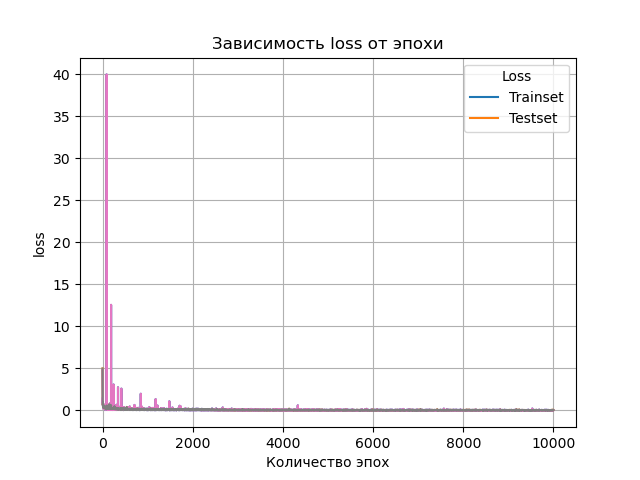

In [23]:
train_losses = []
test_losses = []
mape_errors = []
min_loss = 1000
batch = 0
while (4 == 2 + 2):
    
    for data in trainset:
        X = data [:, 0:-1]
        y = data[:,-1]
        net.zero_grad()
        output = net(X.double())
        loss = loss_function(output.view(-1), y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.cpu().detach().numpy())
    if ((epoch/epochs)*100 % 20 == 0 or (epoch/epochs)*100 > 99.99):
        print('Done', (epoch/epochs)*100, '%')
        print('loss on trainset  =', loss.cpu().detach().numpy())
    for data in testset:
        X = data [:, 0:-1]
        y = data[:,-1]
        output = net(X.double())
        loss = loss_function(output.view(-1), y)
        mape = mean_absolute_percentage_error(output.view(-1), y)
    test_losses.append(loss.cpu().detach().numpy())
    mape_errors.append(mape.cpu().detach().numpy())
    if (loss.cpu().detach().numpy() < min_loss):
        min_loss = loss.cpu().detach().numpy()
        torch.save(net.cpu().state_dict(), '/home/alexander/Рабочий стол/Диплом/pulse/model.pth') # saving model
    if ((epoch/epochs)*100 % 20 == 0 or (epoch/epochs)*100 > 99.99):
        print('loss on testset  = ', loss.cpu().detach().numpy())
        print()

<IPython.core.display.Javascript object>


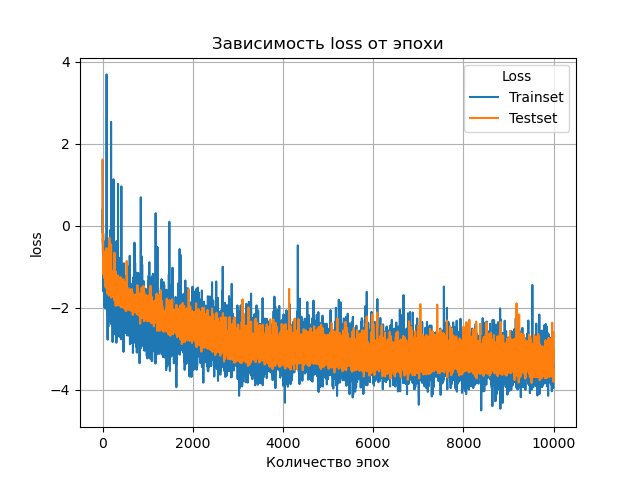

In [61]:
plt.plot(np.log(train_losses[0:-1]))
plt.plot(np.log(test_losses[0:-1]))
#plt.xticks(np.arange(0, 10000, 3000))
plt.grid(True)
plt.xlabel('Количество эпох')
plt.ylabel('loss')
plt.title('Зависимость loss от эпохи')
plt.legend(title='Loss',loc='upper right', labels=['Trainset', 'Testset'])